In [8]:
import pandas as pd
import pickle
import pathlib
import numpy as np

# Loading the data

In [9]:
# Define the base directory for the data and the path to the processed file
DATA_DIR = pathlib.Path.cwd() / 'data'
clean_data_path = DATA_DIR / 'ames_clean.pkl'

# Load the processed dataset from a pickle file
# This dataset should already be cleaned and prepared
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

# Make a copy of the loaded dataset to avoid modifying the original
model_data = data.copy()

# Lists to store nominal and ordinal categorical columns
categorical_columns = []
ordinal_columns = []
# Identify the categorical columns in the dataset
# Split them into ordinal (with implicit order) and nominal (without order)
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:  # Check if the column is ordinal
        ordinal_columns.append(col)
    else:  # Otherwise, treat it as nominal
        categorical_columns.append(col)

# Encode ordinal columns with integer values while preserving the order
# Example: ["low", "medium", "high"] → [0, 1, 2]
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

# Apply One-Hot Encoding to nominal categorical columns
# Create binary columns for each category except the first (drop_first=True)
# This reduces multicollinearity, useful for linear models
model_data = pd.get_dummies(model_data, drop_first=True)

# Reason for no further feature engineering

In this analysis, no further feature engineering was performed, as the dataset was already well-prepared and structured to support reliable modeling. The following points outline the rationale for this approach, including specific examples of transformations previously performed during the preprocessing phase:

1. **High Data Quality:**  
   The dataset had undergone thorough preprocessing, ensuring that any missing values or inconsistencies were resolved. For instance, features that did not make sense to remain separate were logically combined, improving coherence and reducing redundancy. This meticulous cleaning provided a strong foundation for modeling.

2. **Adequate Feature Set:**  
   The existing features captured the key patterns relevant to the predictive task. For example, irrelevant features had already been removed to eliminate noise and enhance the dataset's focus on variables with predictive value. Thus, further modifications were deemed unnecessary.

3. **Avoiding Overfitting and Complexity:**  
   Keeping the dataset simple helped mitigate overfitting risks. Transformations such as converting the target variable (`SalePrice`) to a logarithmic scale were applied where necessary to normalize distributions and improve model performance. However, introducing new transformations at this stage could have added complexity without tangible benefits.

4. **Streamlined Approach:**  
   The dataset’s structure was optimized for modeling, balancing complexity and interpretability. For example, the removal of irrelevant or redundant features ensured the model could concentrate on meaningful information. Additional engineering was avoided to maintain a clear and efficient modeling pipeline.

5. **Practical Performance:**  
   Preliminary evaluations confirmed that the current features supported reliable predictions. With the data already refined—e.g., through targeted transformations like the log scaling of `SalePrice`—no further engineering was needed to enhance performance for the given context.

### Conclusion  

The decision to forgo further feature engineering was intentional, prioritizing simplicity while leveraging the preprocessing steps already performed. By relying on a well-prepared dataset that addressed key challenges like feature relevance and target distribution, the modeling process remained efficient, interpretable, and capable of delivering dependable results.

# Splitting the data into train and test

In [10]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42 

X = model_data.drop('SalePrice', axis=1).copy()
y = model_data['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_SEED,
)

# Training Different Models

### Function to print RMSE and error percentage

In [11]:
from sklearn.metrics import mean_squared_error

def print_errors(y_true, y_pred):
    """Shows RMSE and error percentage for a model's predictions."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    error_percent = 100 * (10 ** rmse -1)

    print(f'RMSE: {rmse:.4f}')
    print(f'Average error: {error_percent:.2f}%')

### Creating lists to store the results

In [ ]:
list_models = []
list_averror = []
list_rmse = []

### Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

print_errors(ytest, ypred)

RMSE: 0.0583
Average error: 14.37%


### Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],    
    'max_depth': [10, 20],          
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [2, 4],        
    'bootstrap': [True]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(Xtrain, ytrain)

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(Xtest)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print_errors(ytest, y_pred)

# Adds the model to the list of models
list_models.append('Random Forest Regressor')
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
list_rmse.append(rmse)
list_averror.append(100 * (10 ** rmse -1))

c:\Users\leosf\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 0.0565
Average error: 13.90%


### Decision Tree Regressor

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt_model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [10, 20, 30],          
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4]        
}

grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(Xtrain, ytrain)

best_dt_model = grid_search.best_estimator_

y_pred = best_dt_model.predict(Xtest)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print_errors(ytest, y_pred)

# Adds the model to the list of models
list_models.append('Decision Tree Regressor')
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
list_rmse.append(rmse)
list_averror.append(100 * (10 ** rmse -1))

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE: 0.0763
Average error: 19.20%


### Ridge Regression 

In [16]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_model = Ridge(random_state=42)

param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(Xtrain, ytrain)

best_ridge_model = grid_search.best_estimator_

y_pred = best_ridge_model.predict(Xtest)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print_errors(ytest, y_pred)

# Adds the model to the list of models
list_models.append('Ridge Regressor')
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
list_rmse.append(rmse)
list_averror.append(100 * (10 ** rmse -1))

Best Hyperparameters: {'alpha': 1}
RMSE: 0.0582
Average error: 14.33%


### XGBoost Regressor

In [17]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 600, 700],   # Number of boosting rounds
    'max_depth': [3, 5, 7],            # Maximum depth of the trees
    'learning_rate': [0.05, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.8, 1.0],           # Fraction of samples used for training each tree
    'colsample_bytree': [0.8, 1.0]     # Fraction of features used for training each tree
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(Xtrain, ytrain)

best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(Xtest)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print_errors(ytest, y_pred)

# Adds the model to the list of models
list_models.append('XGBoost Regressor')
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
list_rmse.append(rmse)
list_averror.append(100 * (10 ** rmse -1))

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.8}
RMSE: 0.0466
Average error: 11.32%


### Ada Boost Regressor

In [18]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

ada_model = AdaBoostRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],    
    'learning_rate': [0.01, 0.1, 1.0],     
}

grid_search = GridSearchCV(
    estimator=ada_model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(Xtrain, ytrain)

best_ada_model = grid_search.best_estimator_

y_pred = best_ada_model.predict(Xtest)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print_errors(ytest, y_pred)

# Adds the model to the list of models
list_models.append('Ada Boost Regressor')
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
list_rmse.append(rmse)
list_averror.append(100 * (10 ** rmse -1))

Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 200}
RMSE: 0.0738
Average error: 18.53%


# Comparing the models

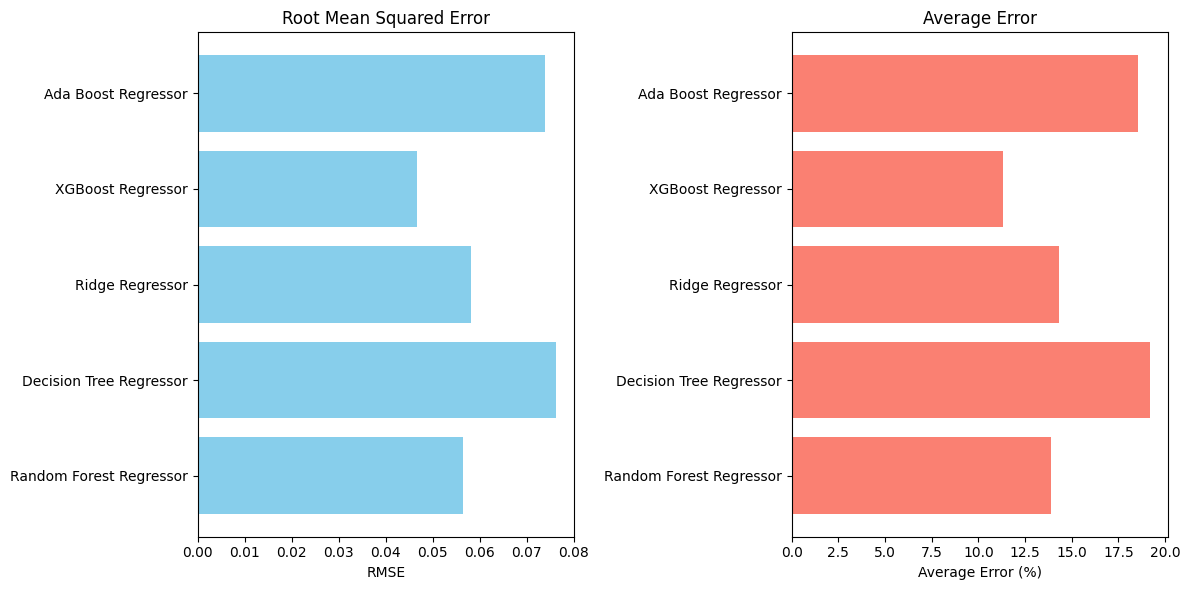

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].barh(list_models, list_rmse, color='skyblue')
ax[0].set_xlabel('RMSE')
ax[0].set_title('Root Mean Squared Error')

ax[1].barh(list_models, list_averror, color='salmon')
ax[1].set_xlabel('Average Error (%)')
ax[1].set_title('Average Error')

plt.tight_layout()
plt.show()

# Choosing the best model:

Based on the comparison of the selected models, the **XGBoost Regressor** was identified as the most suitable model in this context due to its combination of computational efficiency and high predictive accuracy. It effectively handles the logarithmic transformation of the data and delivers consistent predictions, both in absolute and relative terms. With an average error of 11.32%, the model provides reliable general estimates of prices, making it valuable for applications where approximate values are sufficient.

#### Business Implications
1. **Strengths of the Model:**
   - The model is well-suited for scenarios requiring general price estimates, such as strategic planning, market analysis, or trend forecasting.
   - Its efficiency and ease of deployment make it a practical choice for business use, especially in environments with limited computational resources.

2. **Limitations:**
   - The lack of precision limits its use in critical decision-making scenarios, such as high-value property valuations or financial transactions requiring low margins of error.
   - Applications demanding highly detailed analyses may require additional refinement or alternative modeling approaches.

In conclusion, while the **XGBoost Regressor** performs well for general-purpose predictions, its limitations highlight the importance of aligning the model's capabilities with the specific needs of the business application. This ensures that the model adds value without compromising decision-making in critical areas.

# Getting the 10 most important features that affect the price of a house

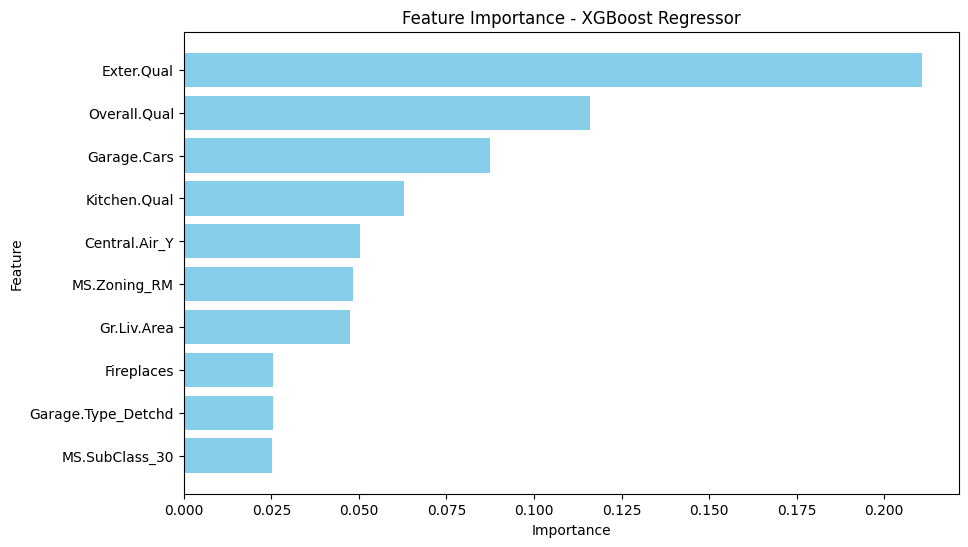

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance
feature_importances = best_xgb_model.feature_importances_

# Creates a DataFrame with the feature importance
importance_df = pd.DataFrame({
    'Feature': Xtrain.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df = importance_df.head(10)

# Plot important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Inverts the y-axis to show the most important feature on top
plt.title('Feature Importance - XGBoost Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Based on the feature importance graph from the XGBoost Regressor, the most critical features in determining property prices are **ExterQual** (external quality of the property), **OverallQual** (overall material and finish quality), and **GarageCars** (the number of cars that fit in the garage). These features significantly influence the model's predictions, indicating their strong correlation with property pricing. Other relevant features include **KitchenQual** (kitchen quality) and **GrLivArea** (above-ground living area), which also contribute to price determination. This highlights the model's capacity to identify key physical and qualitative property attributes as drivers of price.